# Project 1 (Case 1)
In this section we investigate the efficacy of various neural network architectures applied to the Parkinson's classification dataset available on the UCI Machine Learning Repository.

## Exploratory data analysis
We begin by importing the data and generating some summary visuals.

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

In [2]:
raw_data = pd.read_csv('../data/parkinsons/train_data.txt', header=None)
raw_data = raw_data.drop([0, 27], axis=1)
raw_data[[20]] = raw_data[[20]].astype('float64')
raw_data[[21]] = raw_data[[21]].astype('float64')
raw_data[[25]] = raw_data[[25]].astype('float64')
raw_data[[28]] = raw_data[[28]].astype('int64')

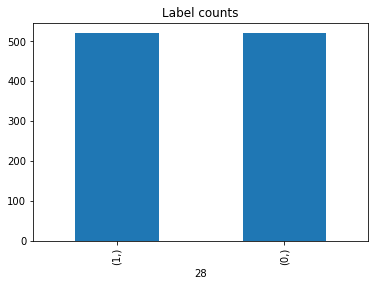

In [3]:
raw_data[[28]].value_counts().plot(kind='bar', title='Label counts')
plt.show()

Clearly the dataset is balanced, in that we have an equal number of examples of each class. This will facilitate training later on. What about the distribution of our 26 input variables?

In [4]:
X = raw_data.loc[:,:26].values
y = raw_data[[28]].values.ravel()

In [5]:
X_scaled = preprocessing.scale(X)

In [6]:
tsne = TSNE()
X_reduced = tsne.fit_transform(X_scaled)

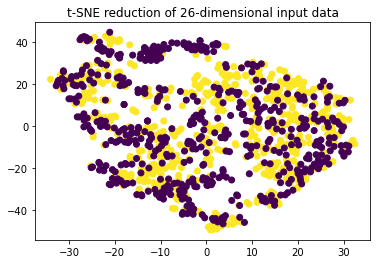

In [7]:
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y)
plt.title('t-SNE reduction of 26-dimensional input data')
plt.show()

Using $t$-SNE, a dimensionality-reduction algorithm, we are able to visualise the 26 inputs dimensions in a scatter plot. Unfortunately it appears that many examples of different classes are clustered together, which suggests that training an accurate classifier may be difficult.

In [8]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)

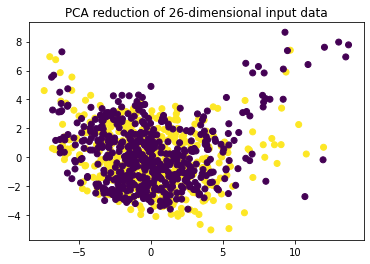

In [9]:
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y)
plt.title('PCA reduction of 26-dimensional input data')
plt.show()

The results are similar for PCA, a liner dimensionality-reduction algorithm. This is clearly a non-trivial classification problem.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
                                    X_scaled, y, test_size=0.20, random_state=42)

## Experimenting with a simple classifier
Before building a neural network, we first experiment with two traditional classifiers to establish a baseline level of performance.

In [13]:
model = LogisticRegression()

model.fit(X_train,y_train)
model.score(X_test,y_test)

0.6875

So with an $\ell_2$-regularised logistic regression classifier, we have obtained a baseline accuracy of $69\%$ on the test set.

In [14]:
model = SVC()

model.fit(X_train,y_train)
model.score(X_test,y_test)

0.7259615384615384

Meanwhile with an out-of-the-box support vector machine, we have obtained a baseline accurace of $73\%$ on the test set. This will be our figure to beat. 

## Building a neural network
We now proceed to building a baseline neural network, which will later be improved upon.

In [34]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(26,128)
        self.fc2 = nn.Linear(128,2)
        
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        
        return x

## Training a neural network
We are now ready to train our neural network.

In [84]:
train_dataset = TensorDataset(
    torch.from_numpy(X_train).type(torch.float),
    torch.from_numpy(y_train)
)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = {
    'X': torch.from_numpy(X_test).type(torch.float),
    'y': torch.from_numpy(y_test)
}

In [85]:
model = Net()

In [86]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [87]:
n_epochs = 1000

train_losses, test_losses = [], []
test_accuracies, test_f1_scores, test_roc_aucs = [], [], []

for e in range(n_epochs):
    
    model.train()
    for ii, (train_inputs, train_labels) in enumerate(train_dataloader):
        optimizer.zero_grad() 

        train_logits = model(train_inputs)
        train_loss = criterion(train_logits, train_labels)

        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item() / train_inputs.shape[0])

    model.eval()
    test_inputs, test_labels = test_dataset['X'], test_dataset['y']
    with torch.no_grad():
        test_logits = model(test_inputs)
        test_loss = criterion(test_logits, test_labels)
    
        preds = test_logits.argmax(dim=1)    
        correct = (preds == test_labels).type(torch.FloatTensor)
        test_accuracy = torch.mean(correct).item()
        
        test_f1_score = f1_score(test_labels, preds)
        test_roc_auc = roc_auc_score(test_labels, test_logits.softmax(dim=1)[:,1])
    
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_f1_scores.append(test_f1_score)
    test_roc_aucs.append(test_roc_auc)

In [92]:
window_length = 50
train_losses_averaged = np.convolve(np.array(train_losses), 
                                    np.ones((window_length,)) / window_length, 
                                    mode='valid')

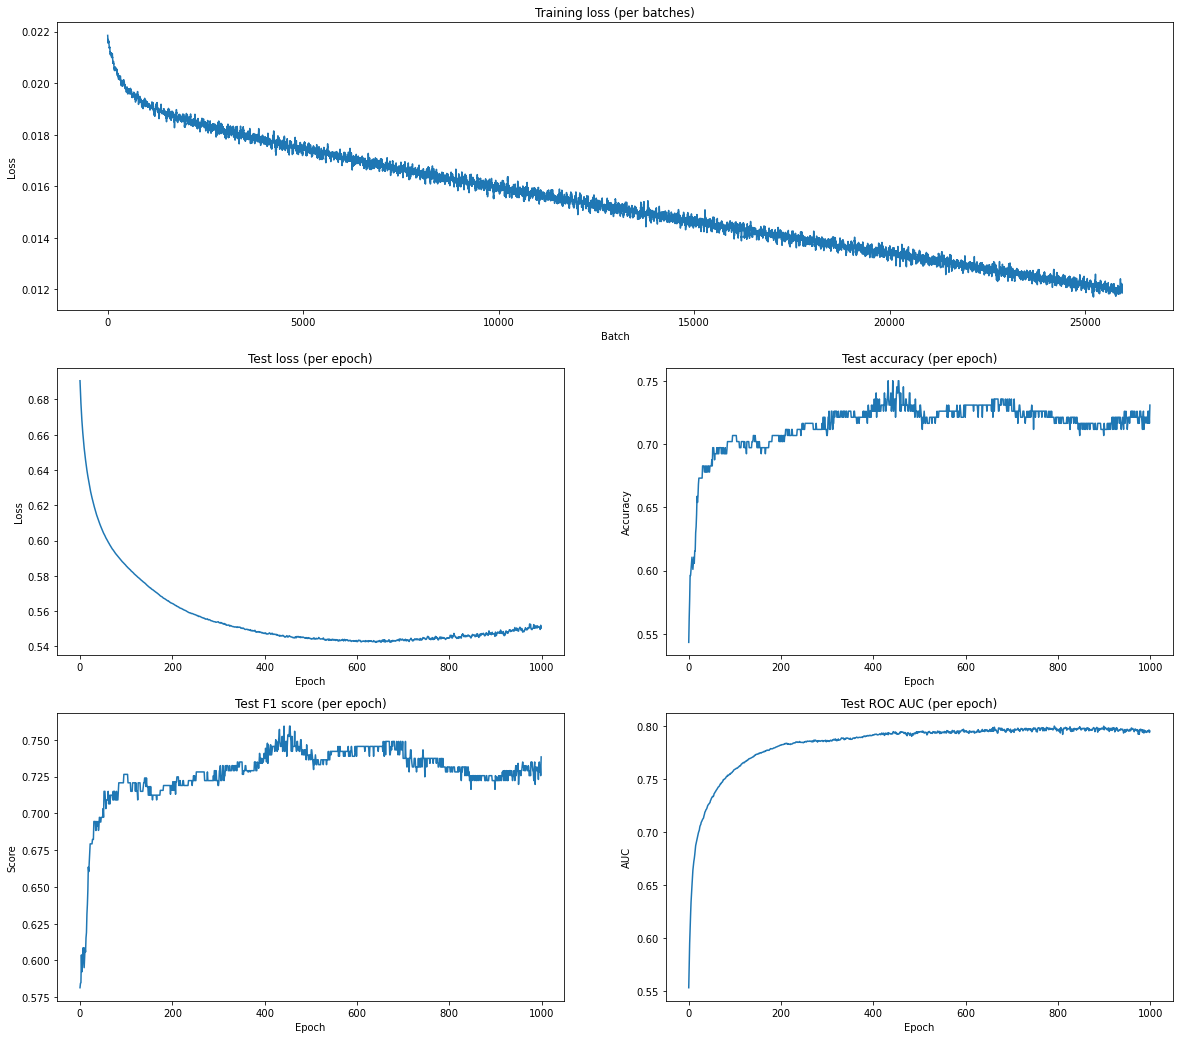

In [93]:
fig = plt.figure(figsize=(20,18))
gs = GridSpec(ncols=2, nrows=3, figure=fig)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])

ax1.plot(train_losses_averaged)
ax2.plot(test_losses)
ax3.plot(test_accuracies)
ax4.plot(test_f1_scores)
ax5.plot(test_roc_aucs)

ax1.set_title('Training loss (per 50 batches)')
ax1.set_xlabel('Batch')
ax1.set_ylabel('Loss')

ax2.set_title('Test loss (per epoch)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

ax3.set_title('Test accuracy (per epoch)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')

ax4.set_title('Test F1 score (per epoch)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Score')

ax5.set_title('Test ROC AUC (per epoch)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('AUC')

plt.show()

Already we see all the classical hallmarks of the training process: monotonic training loss and parabolic test curves, together suggesting that our network starts to overtrain after the $500$th epoch. The maximum accuracy attained on the test set is $75\%$.

## Experimentation
Now we consider a number of experiments. Before doing so, we first wrap some of the above code into functions.

In [95]:
def train_model(train_dataloader, test_dataset, 
                  network, optimizer, criterion, n_epochs, 
                  experiment_name, window_length=50):
    
    train_losses, test_losses = [], []
    test_accuracies, test_f1_scores, test_roc_aucs = [], [], []

    for e in range(n_epochs):

        network.train()
        for ii, (train_inputs, train_labels) in enumerate(train_dataloader):
            optimizer.zero_grad() 

            train_logits = network(train_inputs)
            train_loss = criterion(train_logits, train_labels)

            train_loss.backward()
            optimizer.step()

            train_losses.append(train_loss.item() / inputs.shape[0])

        
        network.eval()
        test_inputs, test_labels = test_dataset['X'], test_dataset['y']
        with torch.no_grad():
            test_logits = network(test_inputs)

            test_loss = criterion(test_logits, test_labels)

            preds = test_logits.argmax(dim=1)    
            correct = (preds == test_labels).type(torch.FloatTensor)
            test_accuracy = torch.mean(correct).item()

            test_f1_score = f1_score(test_labels, preds)
            test_roc_auc = roc_auc_score(test_labels, test_logits.softmax(dim=1)[:,1])

        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        test_f1_scores.append(test_f1_score)
        test_roc_aucs.append(test_roc_auc)
        
    train_losses_averaged = np.convolve(np.array(train_losses), 
                                        np.ones((window_length,)) / window_length, 
                                        mode='valid')
        
    results = {'train_losses': train_losses,
               'train_losses_averaged': train_losses_averaged,
               'test_losses': test_losses, 
               'test_accuracies': test_accuracies,
               'test_f1_scores': test_f1_scores,
               'test_roc_aucs': test_roc_aucs,
               'experiment_name': experiment_name}
    return results

def plot_results(experiment_results, window_length=50):
    
    fig = plt.figure(figsize=(20,18))
    gs = GridSpec(ncols=2, nrows=3, figure=fig)
    ax1 = plt.subplot(gs[0, :])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[2, 0])
    ax5 = plt.subplot(gs[2, 1])
    
    for experiment in experiment_results:
        ax1.plot(experiment['train_losses_averaged'], label=experiment['experiment_name'])
        ax2.plot(experiment['test_losses'], alpha=0.8)
        ax3.plot(experiment['test_accuracies'], alpha=0.8)
        ax4.plot(experiment['test_f1_scores'], alpha=0.8)
        ax5.plot(experiment['test_roc_aucs'], alpha=0.8)

    ax1.set_title('Training loss (mean per {} batches)'.format(str(window_length)))
    ax1.set_xlabel('Batch')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')

    ax2.set_title('Test loss (per epoch)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')

    ax3.set_title('Test accuracy (per epoch)')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')
    
    ax4.set_title('Test F1 score (per epoch)')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Score')

    ax5.set_title('Test ROC AUC (per epoch)')
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('AUC')

### 1. Optimisers
Let us first consider the effects of two different optimisers: Adam and SGD. To make the latter more interesting, we add some momentum.

In [99]:
model_adam = Net()
optimiser_adam = optim.AdamW(model_adam.parameters(), lr=0.0005)

model_SGD = Net()
optimiser_SGD = optim.SGD(model_SGD.parameters(), lr=0.005, momentum=0.5)

results_adam = train_model(train_dataloader, test_dataset, model_adam, optimiser_adam, 
                             nn.CrossEntropyLoss(), 250, 
                             'AdamW')
results_SGD = train_model(train_dataloader, test_dataset, model_SGD, optimiser_SGD, 
                            nn.CrossEntropyLoss(), 250, 
                            'SGD')

experiment_results = [results_adam, results_SGD]

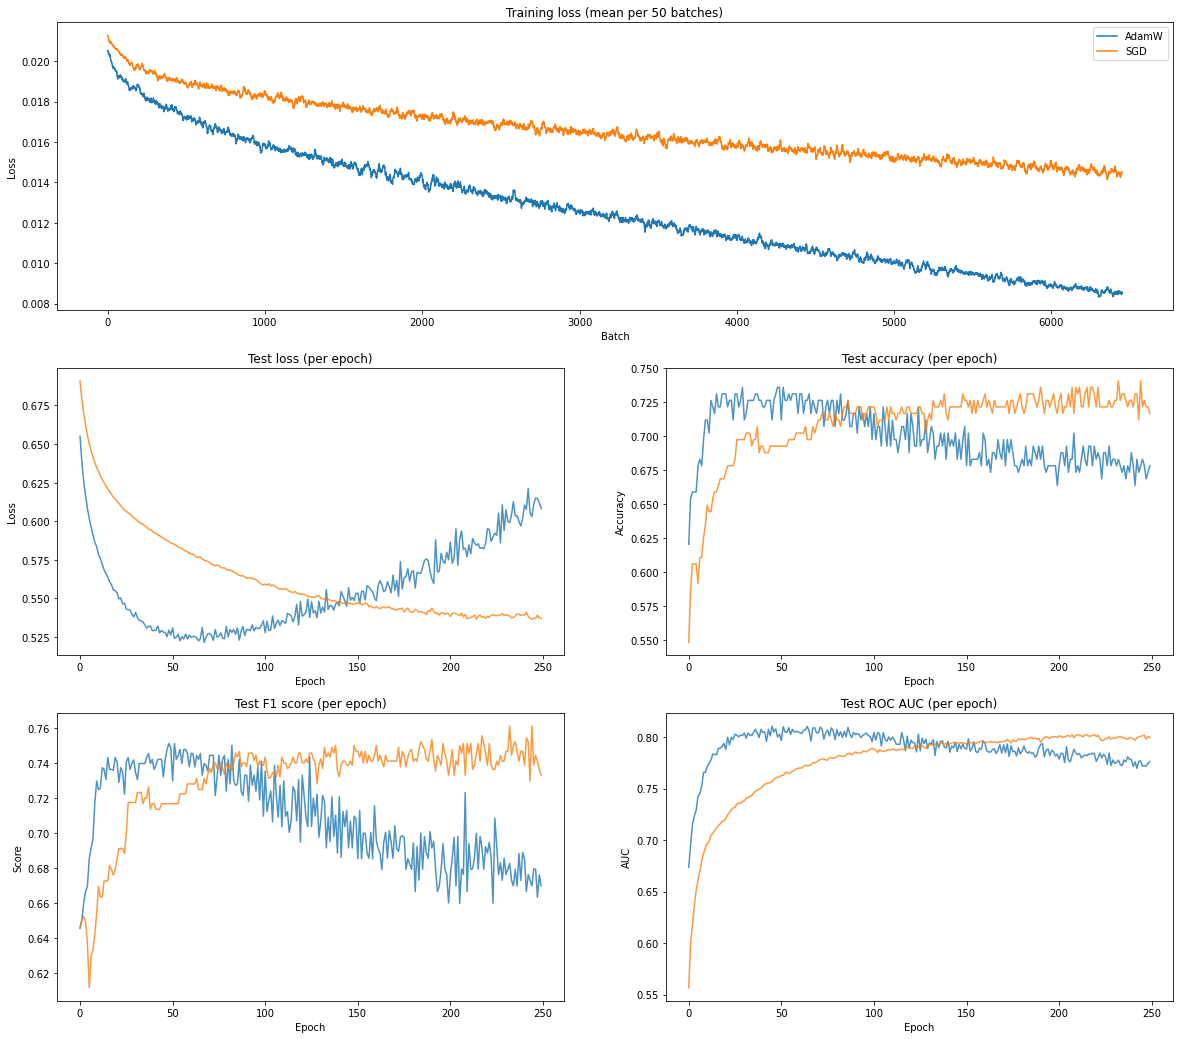

In [100]:
plot_results(experiment_results)

### 2. Learning Rate and Momentum
Since SGD has had more consistent success, we experiment with the learning rate and momentum applied to it.

In [101]:
n_experiments = 4
learning_rates = [0.5, 0.05, 0.005, 0.0005]

models, optimisers = [], []
for i in range(n_experiments):
    model = Net()
    optimiser = optim.SGD(model.parameters(), lr=learning_rates[i])
    models.append(model)
    optimisers.append(optimiser)

experiment_results = []
for i in range(n_experiments):
    experiment_results.append(train_model(train_dataloader, test_dataset, 
                                            models[i], optimisers[i],
                                            nn.CrossEntropyLoss(), 250, 
                                            'lr: {}'.format(str(learning_rates[i]))))

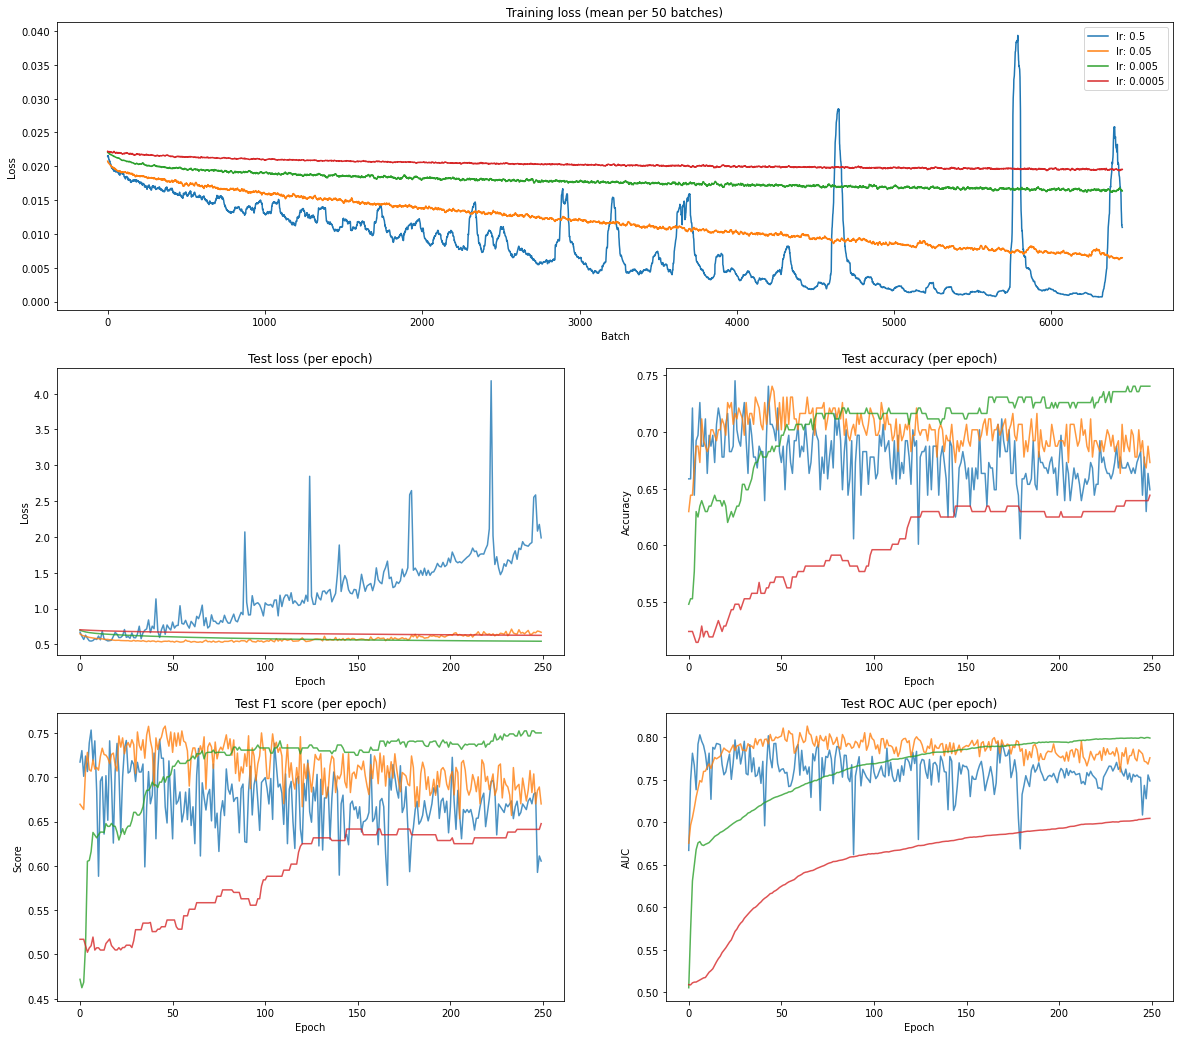

In [102]:
plot_results(experiment_results)

### 3. Network Depth
Next we experiment with the actual structure of the network which is being trained. In particular, we will try adding layers to the network. To this end, I first define a simple ```QuickNet``` class which takes as initialisation arguments a list of layer sizes.

In [104]:
class QuickNet(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()

        self.layer_sizes = layer_sizes

        structure = []
        for i in range(len(layer_sizes)):
            if i == len(layer_sizes) - 2:
                structure.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
                break
            else:
                structure.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
                structure.append(nn.ReLU())

        self.layers = nn.ModuleList(structure)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [105]:
n_experiments = 3
layer_sizes = [
    (26, 32, 2),
    (26, 32, 32, 32, 2),
    (26, 32, 32, 32, 32, 32, 2),
]

models, optimisers = [], []
for i in range(n_experiments):
    model = QuickNet(layer_sizes[i])
    optimiser = optim.SGD(model.parameters(), lr=0.005)
    models.append(model)
    optimisers.append(optimiser)

    
experiment_results = []
for i in range(n_experiments):
    experiment_results.append(train_model(train_dataloader, test_dataset, 
                                            models[i], optimisers[i],
                                            nn.CrossEntropyLoss(), 1000, 
                                            str(models[i].layer_sizes)))

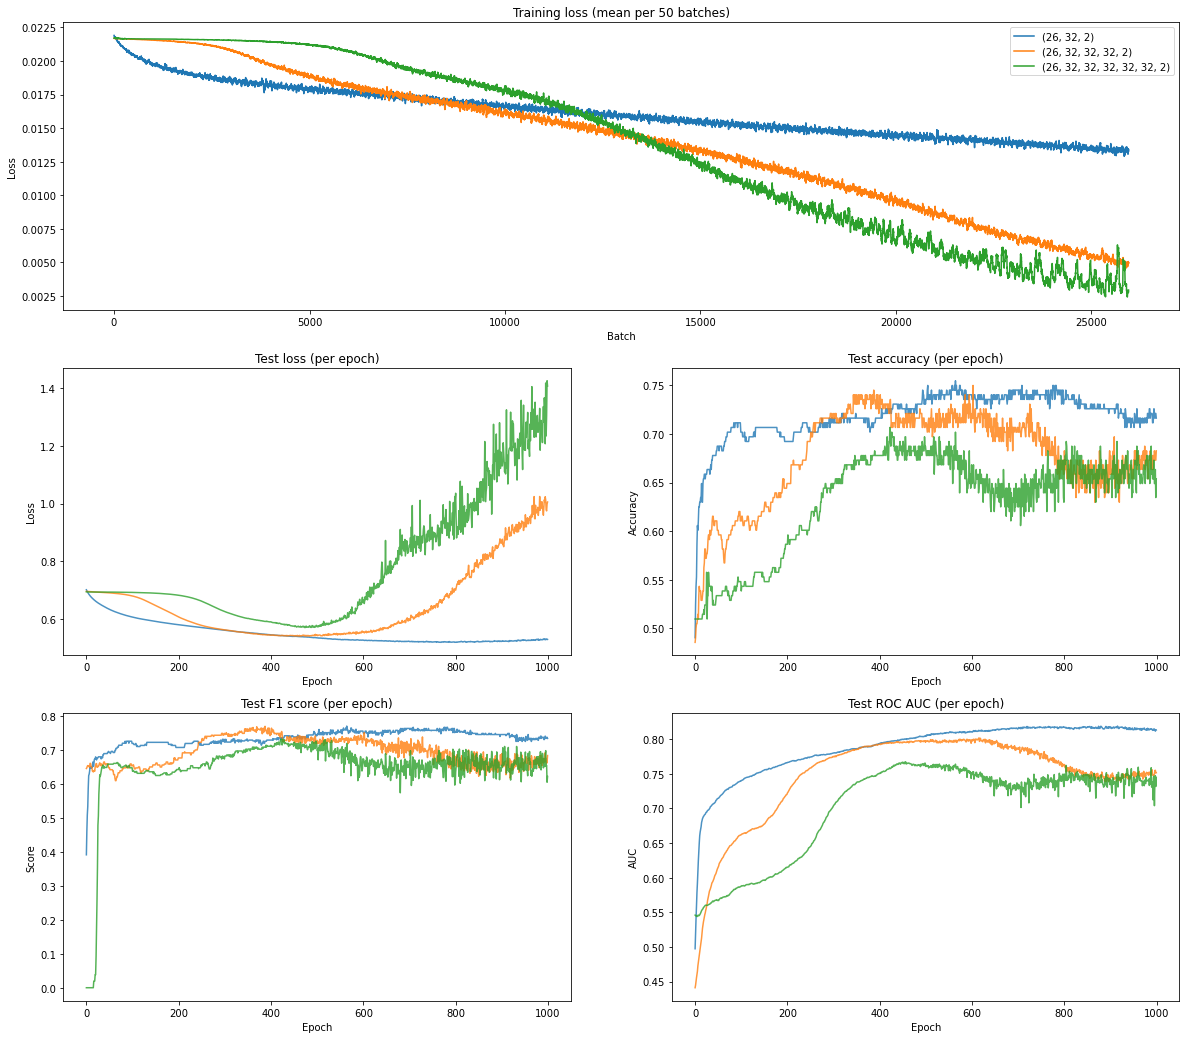

In [106]:
plot_results(experiment_results)

### 4. Network Width
Last we experiment with the width of the network. This is again done using the ```QuickNet``` class.

In [107]:
n_experiments = 4
layer_sizes = [
    (26, 32, 2),
    (26, 64, 2),
    (26, 128, 2),
    (26, 256, 2)
]

models, optimisers = [], []
for i in range(n_experiments):
    model = QuickNet(layer_sizes[i])
    optimiser = optim.SGD(model.parameters(), lr=0.005)
    models.append(model)
    optimisers.append(optimiser)

    
experiment_results = []
for i in range(n_experiments):
    experiment_results.append(train_model(train_dataloader, test_dataset, 
                                            models[i], optimisers[i],
                                            nn.CrossEntropyLoss(), 1000, 
                                            str(models[i].layer_sizes)))

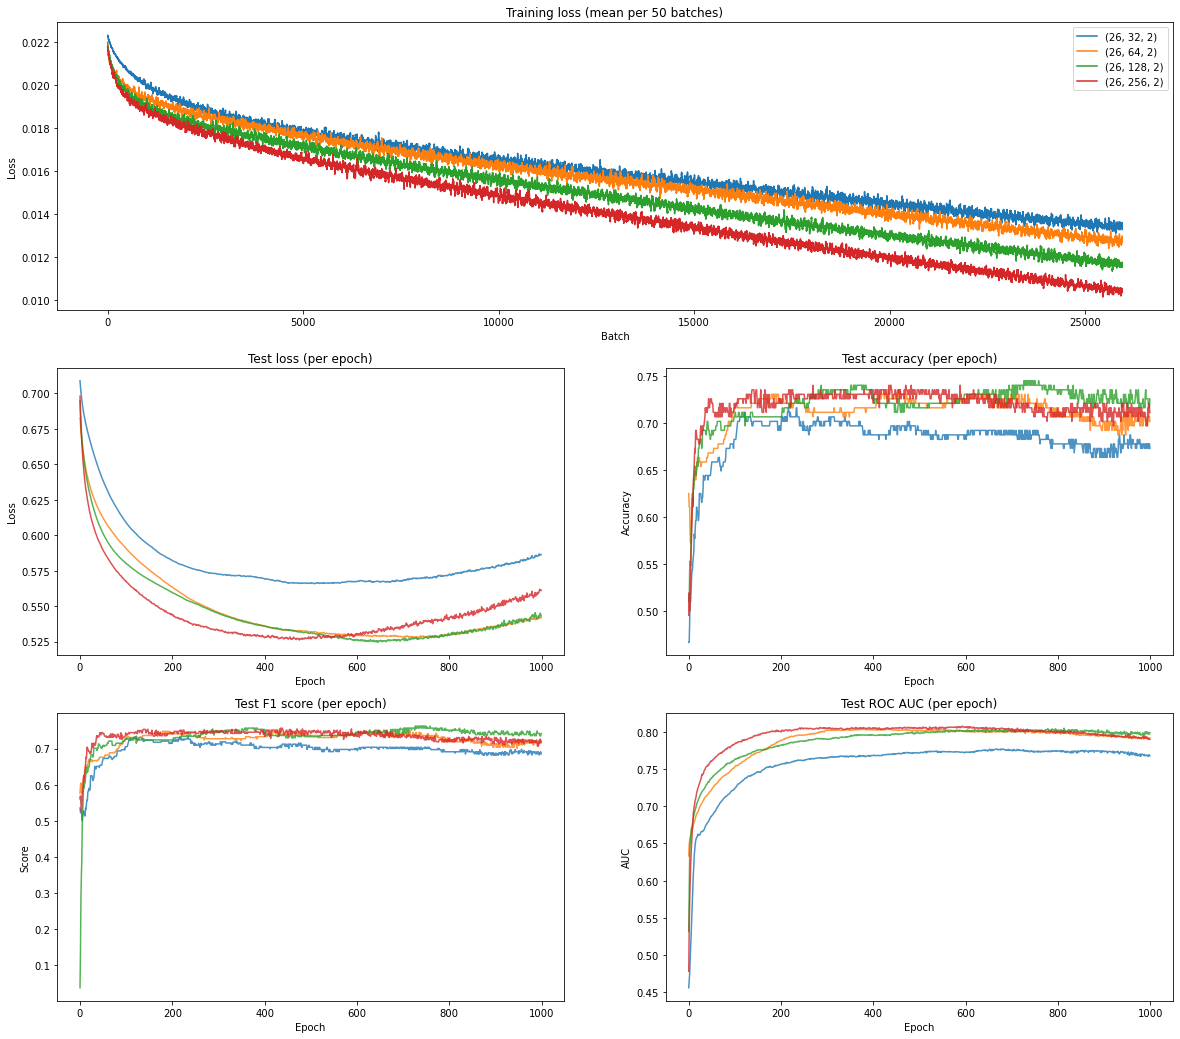

In [108]:
plot_results(experiment_results)

## Evaluation
Across the above, we have explored the performance of various network configurations. In fact it appears that accuracy of $75\%$ is the upper limit of model performance. This was achieved with a number of middling networks; fore example, a model of medium width and depth, trained using SGD with a medium learning rate.

In [109]:
model = QuickNet([26, 128, 128, 2])
optimiser = optim.SGD(model.parameters(), lr=0.005)

experiment_results = train_model(train_dataloader, test_dataset, 
                                            model, optimiser,
                                            nn.CrossEntropyLoss(), 1000, 
                                            'Best Model')
experiment_results = [experiment_results]

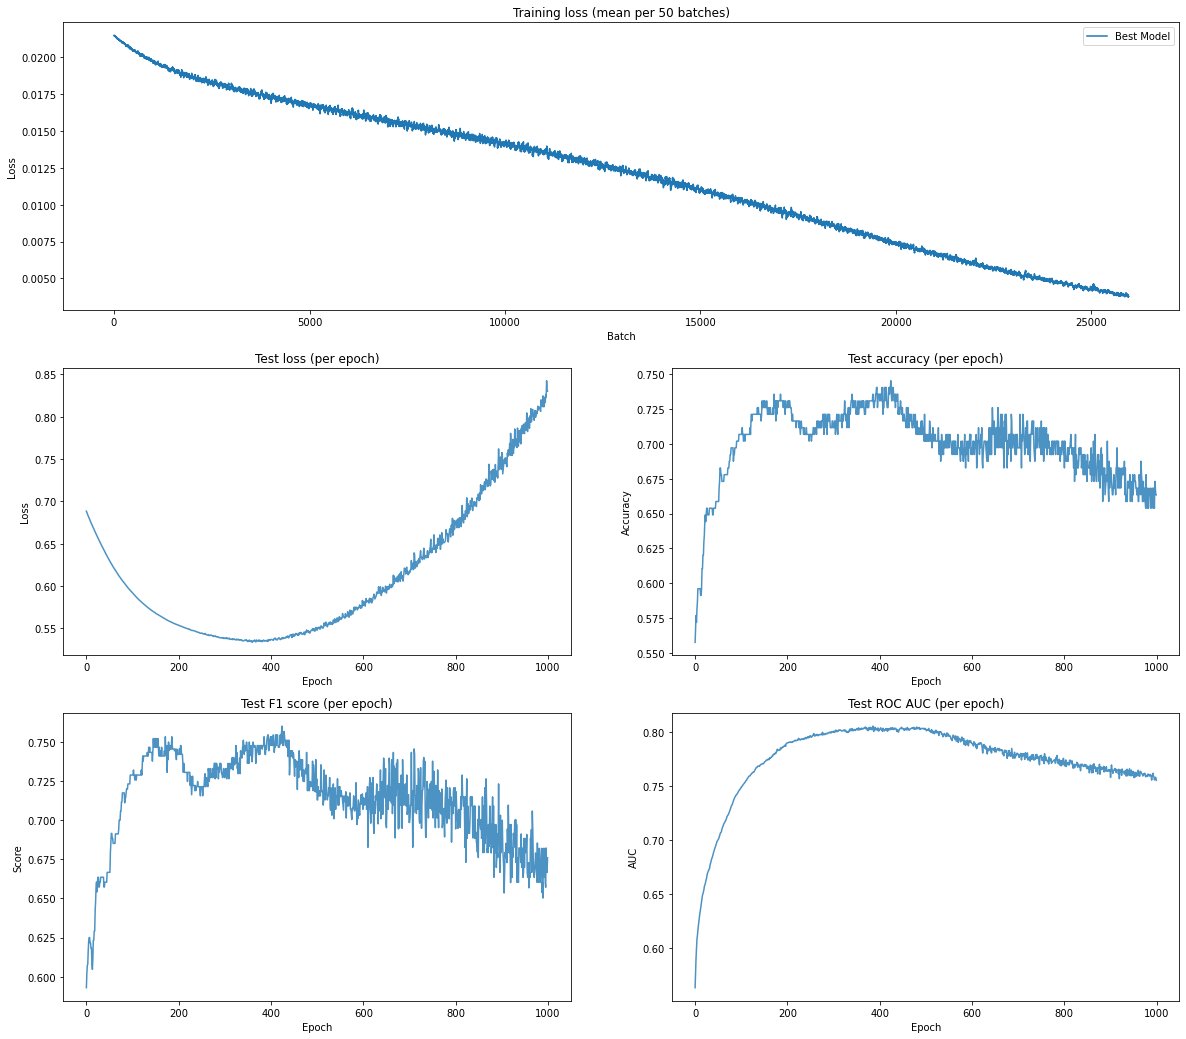

In [110]:
plot_results(experiment_results)